## Feature Extraction and Fine Tuning on Image Dataset with VGG16


In [33]:
#import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import glob
import seaborn as sns
import plotly.figure_factory as ff
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from keras.layers import Dropout
from keras import models
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.applications import VGG16
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

# #unzip test file 
# from zipfile import ZipFile
# file_name = '/content/data'
# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('done')

In [134]:
#use glob to import images, creating arrays of images and corresponding labels 

import glob
Humans = glob.glob('/content/data/Humans/*.*')
cats = glob.glob('/content/data/cats/*.*')
dogs = glob.glob('/content/data/dogs/*.*')
horses = glob.glob('/content/data/horses/*.*')

data = []
labels = []


for i in Humans:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in cats:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in dogs:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in horses:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(3)

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, ytrain, test_size=0.2,
                                                  random_state=42)

In [85]:
#print shape of arrays 
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(ytest.shape)

(516, 224, 224, 3)
(130, 224, 224, 3)
(162, 224, 224, 3)
(516,)
(130,)
(162,)


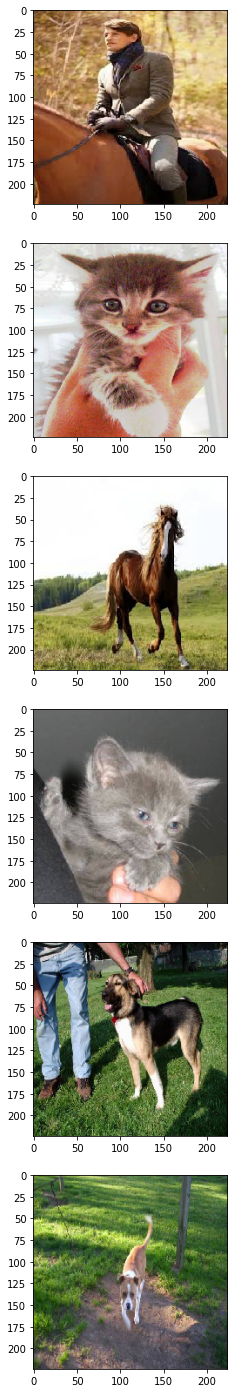

In [86]:
#display random iamges 
ims = X_train[np.random.choice(X_train.shape[0], 6, replace=False)]
fig, ax = plt.subplots(len(ims), figsize=(25, 25))
for i in range(6):
  ax[i].imshow(ims[i])

## VGG Feature Extraction 

In [87]:
## import VGG 16


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model
IMG_SIZE = 224
LR = 1e-4
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [88]:
#set model 
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [89]:
#set last dense ouput layer 
last_layer = model.get_layer('fc2').output
out = Dense(4, activation='softmax', name='output')(last_layer)  
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [90]:
#compile model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/data', save_best_only=True)
]

In [99]:
#train model and save history 
history = model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=10, 
                               validation_data=(X_val, y_val),
                               callbacks=my_callbacks)

Epoch 1/10
17/17 [==============================] - 1s 50ms/step - loss: 7.3360e-04 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9769
Epoch 2/10
17/17 [==============================] - 1s 48ms/step - loss: 6.8063e-04 - acc: 1.0000 - val_loss: 0.0685 - val_acc: 0.9769
Epoch 3/10
17/17 [==============================] - 1s 47ms/step - loss: 6.3392e-04 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 0.9769
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 4/10
17/17 [==============================] - 1s 48ms/step - loss: 5.9458e-04 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9769
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 5/10
17/17 [==============================] - 1s 48ms/step - loss: 5.5634e-04 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9769
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 6/10
17/17 [==============================] - 1s 48ms/step - loss: 5.2458e-04 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9769
INFO:tensorflow:Assets

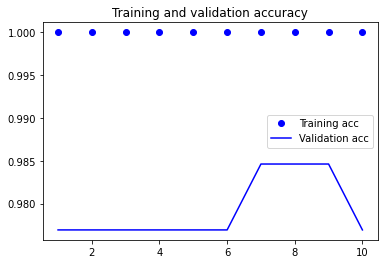

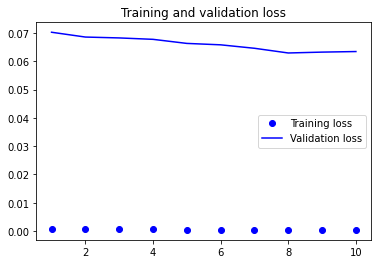

In [100]:
#visualise performance 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:

# from sklearn.metrics import accuracy_score

# ## Test Accuracy
# predictions = model.predict(X_test)
# x = np.round(predictions)
# preds = np.where(x==1)[1]
# test_acc = accuracy_score(ytest, preds)

# from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# precision, recall, f1score, _ = precision_recall_fscore_support(ytest, preds)

# # auc = roc_auc_score(ytest, preds)

# print("Train Accuracy:\t", acc[-1])
# print("Val Accuracy:\t", val_acc[-1])
# print("Test Accuracy:\t", test_acc)
# print("Precision:\t", precision)
# print("Recall:\t\t", recall)
# print("F1 Score:\t", f1score)
# # print("AUC:\t\t", auc)

In [103]:
val_loss, val_accuracy = model.evaluate(X_test, ytest)

6/6 [==============================] - 0s 33ms/step - loss: 0.3129 - acc: 0.9506


##VGG16 For Fine_tuning 

In [104]:
#set model 
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


#set last layers, freeze remaining 
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(4, activation='softmax', name='output')(x) 
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

#compile model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#set call backs and early stopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/data', save_best_only=True)
]

#train model and save history 
history = model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=10, 
                               validation_data=(X_val, y_val),
                               callbacks=my_callbacks)

Epoch 1/10
17/17 [==============================] - 2s 62ms/step - loss: 20.2518 - acc: 0.4666 - val_loss: 1.4534 - val_acc: 0.9538
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 2/10
17/17 [==============================] - 1s 47ms/step - loss: 0.6331 - acc: 0.9604 - val_loss: 1.2783 - val_acc: 0.9538
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 3/10
17/17 [==============================] - 1s 47ms/step - loss: 0.1120 - acc: 0.9919 - val_loss: 1.8900 - val_acc: 0.9462
Epoch 4/10
17/17 [==============================] - 1s 47ms/step - loss: 0.0475 - acc: 0.9956 - val_loss: 1.5005 - val_acc: 0.9538
Epoch 5/10
17/17 [==============================] - 1s 47ms/step - loss: 0.0082 - acc: 0.9993 - val_loss: 1.3077 - val_acc: 0.9615
Epoch 6/10
17/17 [==============================] - 1s 47ms/step - loss: 2.8262e-04 - acc: 1.0000 - val_loss: 0.6781 - val_acc: 0.9692
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 7/10
17/17 [=======================

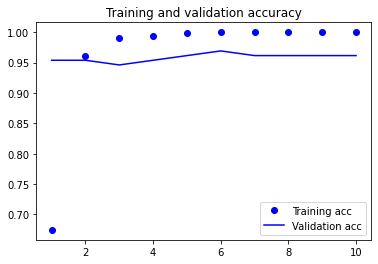

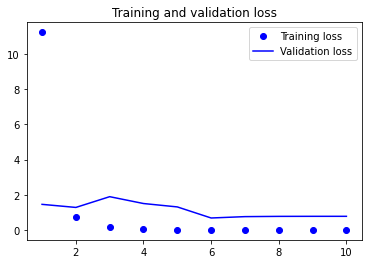

In [105]:
#visualise performance 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [106]:
## performance metrics 
predictions = model.predict(X_test)
x = np.round(predictions)
preds = np.where(x==1)[1]
test_acc = accuracy_score(ytest, preds)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(ytest, preds)

# auc = roc_auc_score(ytest, preds)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
# print("AUC:\t\t", auc)

Train Accuracy:	 1.0
Val Accuracy:	 0.9615384340286255
Test Accuracy:	 0.9382716049382716
Precision:	 [0.97222222 0.97674419 0.90697674 0.9       ]
Recall:		 [0.94594595 0.875      0.95121951 1.        ]
F1 Score:	 [0.95890411 0.92307692 0.92857143 0.94736842]


##Feature extraction on VGG19

In [118]:
model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# model.summary()
#set last layers, freeze remaining 
last_layer = model.get_layer('predictions').output
out = Dense(4, activation='softmax', name='output')(last_layer) 
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

# for i, layer in enumerate(model.layers):
#   print(i, layer.name, "-", layer.trainable)

#compile model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#set call backs and early stopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/data', save_best_only=True)
]

#train model and save history 
history = model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=10, 
                               validation_data=(X_val, y_val),
                               callbacks=my_callbacks)

574717952/574710816 [==============================] - 6s 0us/step
Epoch 1/10
17/17 [==============================] - 2s 71ms/step - loss: 1.3805 - acc: 0.3564 - val_loss: 1.3716 - val_acc: 0.4846
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 2/10
17/17 [==============================] - 1s 57ms/step - loss: 1.3661 - acc: 0.5790 - val_loss: 1.3596 - val_acc: 0.6154
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 3/10
17/17 [==============================] - 1s 57ms/step - loss: 1.3532 - acc: 0.7246 - val_loss: 1.3477 - val_acc: 0.7077
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 4/10
17/17 [==============================] - 1s 57ms/step - loss: 1.3429 - acc: 0.8299 - val_loss: 1.3361 - val_acc: 0.8000
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 5/10
17/17 [==============================] - 1s 57ms/step - loss: 1.3317 - acc: 0.8538 - val_loss: 1.3249 - val_acc: 0.8231
INFO:tensorflow:Assets written to: /content/data/asset

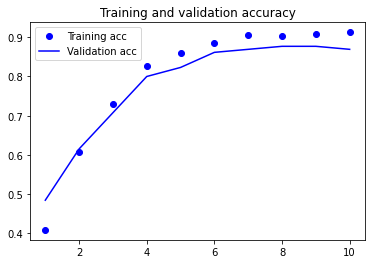

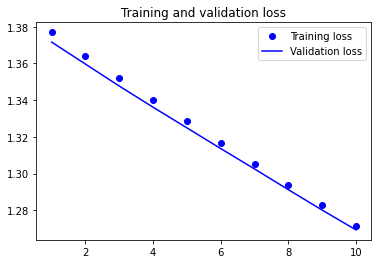

In [119]:
#visualise performance 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [135]:
val_loss, val_accuracy = model.evaluate(X_test, ytest)

6/6 [==============================] - 0s 38ms/step - loss: 1.2761 - acc: 0.8457


## Fine Tuning on VGG19

In [138]:
#set model 
model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


#set last layers, freeze remaining 
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(4, activation='softmax', name='output')(x) 
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

#compile model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#set call backs and early stopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/data', save_best_only=True)
]

#train model and save history 
history = model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=10, 
                               validation_data=(X_val, y_val),
                               callbacks=my_callbacks)

Epoch 1/10
17/17 [==============================] - 2s 71ms/step - loss: 14.6996 - acc: 0.6166 - val_loss: 0.9455 - val_acc: 0.9462
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 2/10
17/17 [==============================] - 1s 56ms/step - loss: 0.2306 - acc: 0.9780 - val_loss: 0.9125 - val_acc: 0.9538
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 3/10
17/17 [==============================] - 1s 56ms/step - loss: 0.1658 - acc: 0.9868 - val_loss: 0.7662 - val_acc: 0.9462
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 4/10
17/17 [==============================] - 1s 57ms/step - loss: 0.0750 - acc: 0.9970 - val_loss: 1.2675 - val_acc: 0.9385
Epoch 5/10
17/17 [==============================] - 1s 57ms/step - loss: 0.1411 - acc: 0.9971 - val_loss: 0.4656 - val_acc: 0.9538
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 6/10
17/17 [==============================] - 1s 58ms/step - loss: 0.0298 - acc: 0.9955 - val_loss: 0.5173 - val_a

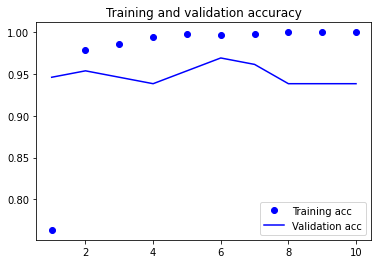

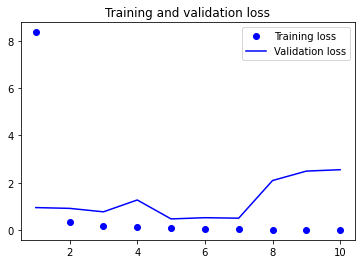

In [139]:
#visualise performance 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [140]:
val_loss, val_accuracy = model.evaluate(X_test, ytest)

6/6 [==============================] - 0s 37ms/step - loss: 5.9387 - acc: 0.8889
